# 
**TP3: Ladybug Trajectory Prediction**

- Binôme 1: BOUCHEZ Raphaël
- Binôme 2: AIT-HAMID Adam

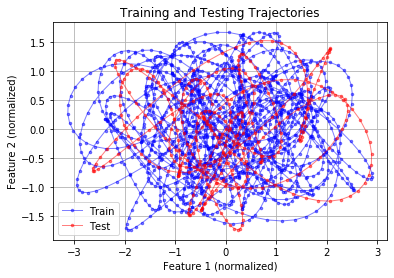


`Objectives`: Build neural networks for multi step time series forecasting.

1. Build `Transformer`/``RNN``/``LSTM``/``GRU``/``MLP`` model(s).
2. Adapt it/them for multistep time series forecasting Memory order $L=20$ and prediction horizon $T=20$
3. Split dataset to train and test set for the ladybug trajectory dataset.
4. Build `Experiment` for training and testing the time series model.
5. Compare performance of different models.
6. (Optional): Implement a simplified version of Reversible Instance Normalization, examine its performance.
7. Make a **conclusion** with experiments results.

**Remark**: Do not generate too many graphs and text, make sure your notebook is clean and readable.


In [96]:
import numpy as np
from math import cos, sin
import random

### Initialization with ladybug_init(s)
The ladybug_init function initializes the parameters for the ladybug's movement. It takes an optional seed value s for the random number generator to ensure reproducibility of the simulation. If s is greater than zero, the seed is set, ensuring that the random numbers generated are the same for each run with the same seed. The function then creates two lists, params_x and params_y, each containing 8 parameters drawn from a Gaussian (normal) distribution with a mean of 0 and a standard deviation of 1. These parameters (ax1 to ax4, kx1 to kx4 for the x direction, and similarly ay1 to ay4, ky1 to ky4 for the y direction) influence the oscillatory motion of the ladybug in both the x and y directions, respectively.

### Movement Simulation with ladybug_move(t)
The ladybug_move function calculates the ladybug's position (x, y) at a given time t. It retrieves the previously initialized parameters for the x and y directions. The position of the ladybug at time t is determined by a combination of sinusoidal and cosinusoidal functions, which are commonly used to model periodic or oscillatory motions. Specifically, the x-coordinate is calculated as a sum of:

sine and cosine functions of t, scaled by parameters that adjust the frequency (kx1 to kx4 with added constants to ensure non-zero frequencies) and amplitude (ax1 to ax4).
The y-coordinate is similarly calculated but with its own set of parameters (ay1 to ay4 for amplitude and ky1 to ky4 for frequency) and a mix of sine and cosine functions.



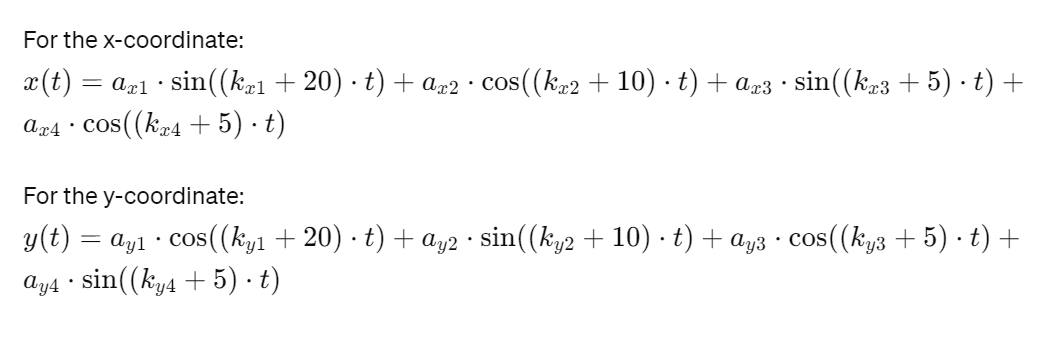


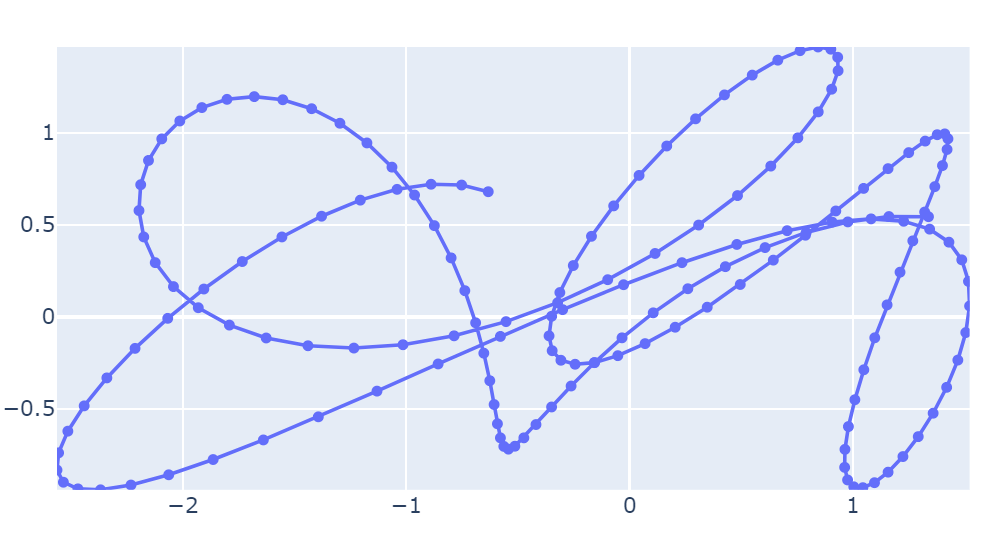

In [97]:
def ladybug_init(s=122):
    
    if s>0 : random.seed(s)
    ladybug_init.params_x = [ random.gauss(0.,1.) for u in range(8)]
    ladybug_init.params_y = [ random.gauss(0.,1.) for u in range(8)]
    
def ladybug_move(t):

    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4] = ladybug_init.params_x
    [ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = ladybug_init.params_y
    
    x = ax1*sin(t*(kx1+20)) + ax2*cos(t*(kx2+10)) + ax3*sin(t*(kx3+5)) + ax4*cos(t*(kx4+5))
    y = ay1*cos(t*(ky1+20)) + ay2*sin(t*(ky2+10)) + ay3*cos(t*(ky3+5)) + ay4*sin(t*(ky4+5)) 

    return x,y

### Datasets
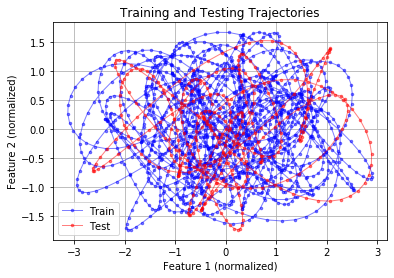

**Parameters for lady bug simulation**


In [98]:
# ---- About dataset ----------------#
max_t        = 100
delta_t      = 0.01
features_len = 2


sequence_len = 20
predict_len  = 5

# ---- About training ---------------#
scale         = .2       # Percentage of dataset to be used (1=all)
train_prop    = .8       # Percentage for train (the rest being for the test)
batch_size    = 32
epochs        = 5
fit_verbosity = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

In [99]:
# ---- Get positions
#
ladybug_init(s=16)
x,y = 0,0
positions=[]
for t in np.arange(0., max_t, delta_t):
    x,y = ladybug_move(t)
    positions.append([x,y])

# ---- Build rescaled dataset
#
n = int( len(positions)*scale )
dataset = np.array(positions[:n])

k = int(len(dataset)*train_prop)
x_train = dataset[:k]
x_test  = dataset[k:]

# ---- Normalize
#
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

print("Dataset generated.")
print("Train shape is : ", x_train.shape)
print("Test  shape is : ", x_test.shape)

Dataset generated.
Train shape is :  (1600, 2)
Test  shape is :  (400, 2)


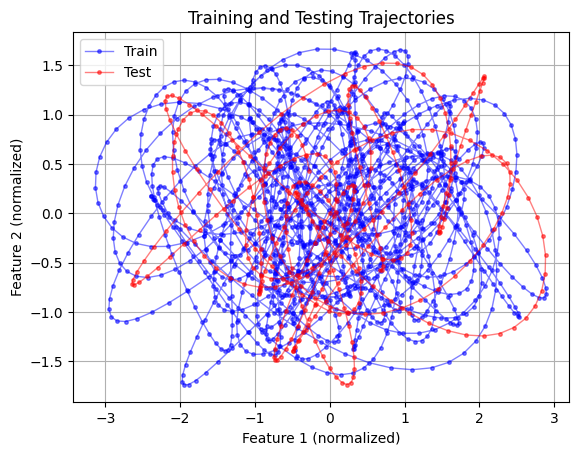

In [100]:
import matplotlib.pyplot as plt

# Plot training data points as a line
plt.plot(x_train[:, 0], x_train[:, 1], c='blue', label='Train', marker='.', markersize=5, linestyle='-', linewidth=1, alpha=0.5)

# Plot testing data points as a line
plt.plot(x_test[:, 0], x_test[:, 1], c='red', label='Test', marker='.', markersize=5, linestyle='-', linewidth=1, alpha=0.5)

# Label the axes, add a legend, and show the plot
plt.xlabel('Feature 1 (normalized)')
plt.ylabel('Feature 2 (normalized)')
plt.title('Training and Testing Trajectories')
plt.legend()
plt.grid(True)
plt.show()


### Models
#### 1. Recurrent Neural Network Model
Recurrent Neural Networks (RNN) keep of form of memory regarding previous inputs. Its back propagation uses a specific alternative called Backpropagation Through Time (BPTT). BPTT computes gradients for each time step and then updates the weights differently for each of them depending on the contribution of the time step to the final output.

#### 2. Long Short-Term Memory Model
Long Short-Term Memory Model (LSTM) is a derivative of RNN that tend to resolve part of the problems of the architecture in vanishing and exploding gradient problem that happen respectively when a gradient gets attributed a weight so small or so big that its contribution almost becomes an outlier. This model selectively remembers information by using different variables called gates in order to maintain them on longer sequences.

#### 3. Gated Recurrent Unit
The Gated Recurrent Unit Model (GRU) is a simplification of the LSTM. It merges gates together to simplify the implementation.

#### 4. Multi Layer Perceptron
The Multi Layer Perceptron (MLP) is a simple Neural Network that consists of an input layer, a Hidden layer and an output layer.

In [101]:
from keras import Sequential, Model
from keras.src import layers

# 1. Build `Transformer`/``RNN``/``LSTM``/``GRU``/``MLP`` model(s).

# RNN Model
rnn_model = Sequential([
    layers.InputLayer(shape=(20,2)),
    layers.SimpleRNN(50, activation='relu', return_sequences=True),
    layers.TimeDistributed(layers.Dense(2))
])
rnn_model.compile(optimizer='rmsprop', loss='mse')

# LSTM Model
lstm_model = Sequential([
    layers.InputLayer(shape=(20,2)),
    layers.LSTM(50, activation='relu', return_sequences=True),
    layers.TimeDistributed(layers.Dense(2))
])
lstm_model.compile(optimizer='rmsprop', loss='mse')

# GRU Model
gru_model = Sequential([
    layers.InputLayer(shape=(20,2)),
    layers.GRU(50, activation='relu', return_sequences=True),
    layers.TimeDistributed(layers.Dense(2))
])
gru_model.compile(optimizer='rmsprop', loss='mse')

# Multi Layer Perceptron
mlp_model = Sequential([
    layers.InputLayer(shape=(20,2)),
    layers.Dense(50, activation='relu'),
    layers.Dense(2),  # 20 Time steps * 2 features per timestep
    layers.Reshape((20, 2))  # Reshape the output
])
mlp_model.compile(optimizer='rmsprop', loss='mse')

#### 5. Transformer Model
The Transformer Model is based on attention. This concept lets the model study every part of the data as well as the relations between them. The model is capable of grasping the relations between every part of the input to reach an understanding allowing him to predict sequentially what comes next.

The Transformer Model will first perform an embedding. This process will simply vectorize our input. Then, it is going to use positional encoding. It means that it will consider the position of every part of data in the series to determine an encoding. After that, a decoder will translate the values and pass them to a dense output layer.

In [102]:
# Function that gets the positional encoding for the input data
# We place every part of the data in a big matrix, and we compute their value based on the position they have
def get_positional_encoding(timeseries_length, d_model):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (i // 2) / d_model) for i in range(d_model)]
        for pos in range(timeseries_length)
    ])
    pos_enc[:, 0::2] = np.sin(pos_enc[:, 0::2])  # Apply sin to even indices.
    pos_enc[:, 1::2] = np.cos(pos_enc[:, 1::2])  # Apply cos to odd indices.
    return pos_enc

# Transformer Model
def build_transformer_model():
    # Input
    inputs = layers.Input(shape=(20,2))
    positional_encoding = get_positional_encoding(20, 2)
    inputs += positional_encoding
    
    # Multi Head Attention with its Dropout and Normalization to stabilize it
    attention = layers.MultiHeadAttention(num_heads=2, key_dim=50)(inputs, inputs, inputs)
    attention = layers.Dropout(0.1)(attention)
    attention = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed Forward Network
    ffn = layers.Dense(50, activation='relu')(attention)
    ffn = layers.Dense(2)(ffn)
    ffn = layers.Dropout(0.1)(ffn)
    ffn = layers.LayerNormalization(epsilon=1e-6)(attention + ffn)
    
    # Output
    outputs = ffn
    
    # Finally, create the model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model
    
transformer_model = build_transformer_model()

### Experiments 

In [103]:
# Training parameters
epochs=200
batch_size=128

# First, we need to get our data that is going to be fed to the model.
# We want our models to be able to predict T = 20 time steps of the ladybug's position in the future based on L = 20 pastime steps.
# In order to do so, we will iterate over our dataset, register every slice of 20 positions as input and the next 20 ones as output
def prepare_data(data):
    x, y =  [], []
    for i in range(len(data) - 20 - 20):
        x.append(data[i:i+20])
        y.append(data[i+20+1:i+20+1+20])
        
    return x, y

train_input, train_output = prepare_data(x_train)
test_input, test_output = prepare_data(x_test)

# We split the training data again to get some validation data
idx = int(len(train_input) * 0.2)
train_input = np.asarray(train_input[idx:])
train_output = np.asarray(train_output[idx:])
valid_input = np.asarray(train_input[:idx])
valid_output = np.asarray(train_output[:idx])
test_input = np.asarray(test_input)
test_output = np.asarray(test_output)

# Now, we can train our models
rnn_history = rnn_model.fit(
    x=train_input,
    y=train_output,
    validation_data=(valid_input, valid_output),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

lstm_history = lstm_model.fit(
    x=train_input,
    y=train_output,
    validation_data=(valid_input, valid_output),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

gru_history = gru_model.fit(
    x=train_input,
    y=train_output,
    validation_data=(valid_input, valid_output),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

mlp_history = mlp_model.fit(
    x=train_input,
    y=train_output,
    validation_data=(valid_input, valid_output),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

transformer_history = transformer_model.fit(
    x=train_input,
    y=train_output,
    validation_data=(valid_input, valid_output),
    epochs=epochs,
    batch_size=batch_size,
    verbose=0
)

# Evaluating the models on the test dataset
rnn_test_loss = rnn_model.evaluate(test_input, test_output, verbose=0)
lstm_test_loss = lstm_model.evaluate(test_input, test_output, verbose=0)
gru_test_loss = gru_model.evaluate(test_input, test_output, verbose=0)
mlp_test_loss = mlp_model.evaluate(test_input, test_output, verbose=0)
transformer_test_loss = transformer_model.evaluate(test_input, test_output, verbose=0)

# Printing the evaluation results
print(f"RNN Test Loss: {rnn_test_loss}")
print(f"LSTM Test Loss: {lstm_test_loss}")
print(f"GRU Test Loss: {gru_test_loss}")
print(f"MLP Test Loss: {mlp_test_loss}")
print(f"Transformer Test Loss: {transformer_test_loss}")

RNN Test Loss: 1.1715564727783203
LSTM Test Loss: 1.0137410163879395
GRU Test Loss: 1.0036472082138062
MLP Test Loss: 1.036015272140503
Transformer Test Loss: 1.049519658088684


### Results 
A good way to compare these models performances is to print their loss values on a unique graph.

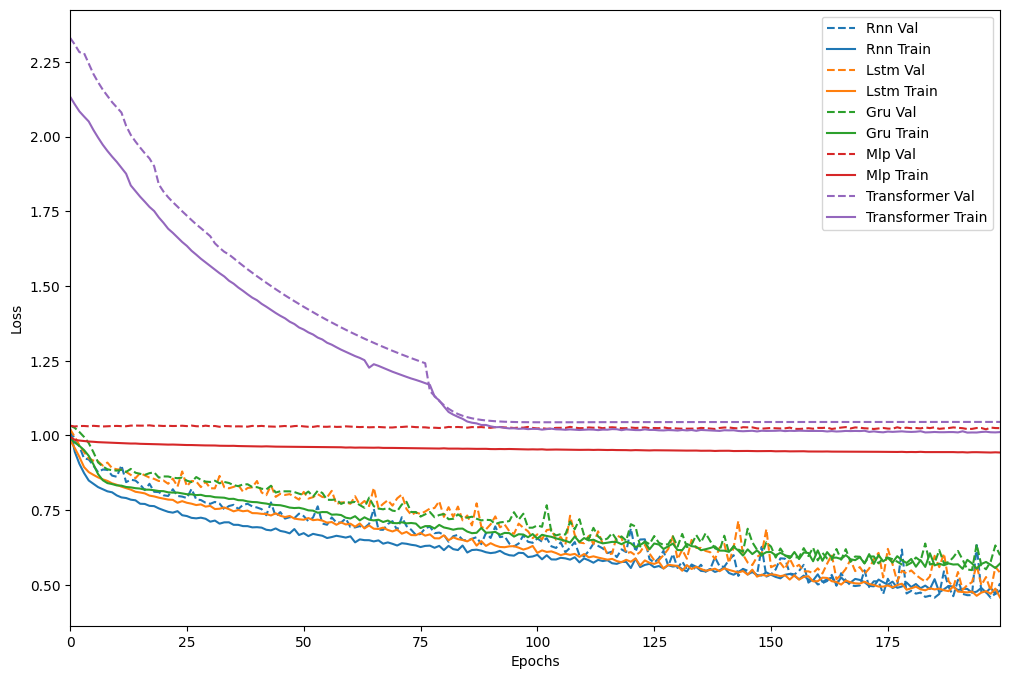

In [104]:
# Function to plot the history of each model
def plot_history(histories):
    plt.figure(figsize=(12, 8))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_loss'],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel('loss'.replace('_', ' ').title())
    plt.legend()
    
    plt.xlim([0, max(history.epoch)])
    plt.show()

# Plotting the history
plot_history([
    ('rnn', rnn_history),
    ('lstm', lstm_history),
    ('gru', gru_history),
    ('mlp', mlp_history),
    ('transformer', transformer_history)
])

### Conclusion
According to the obtained results, we can establish a clear separation of performance between two categories. The Transformer Model and the MLP Model scored a significantly worse score than the GRU, LSTM and RNN models. It comes as a surprise in this use case because the complex architecture of the Transformer Model and his attention mechanisms seemed to be a really efficient way to better understand the position of a ladybug for a given time step. Maybe the implementation used in this notebook could not get the most out of these concepts. However, we are forced to admit that as it is, the RNN, LSTM and GRU models scored a way better score, with even a slight advantage for the LSTM Model. In fact, it should be logical as the GRU is a simplification of the LSTM and the RNN a basis for it. 